# Preamble

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Recommenders

!pip install pytorch-lightning
!pip install optuna

import os
import io
import pickle
import warnings
from copy import deepcopy
from zipfile import ZipFile
from datetime import datetime
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

from uncertain.utils.data import Data
from uncertain.utils.training import train
from uncertain.utils.evaluation import test
from uncertain.explicit import Bias, MF, CPMF, OrdRec, BeMF
from uncertain.extras import Ensemble, Resample, UncertainWrapper, UserHeuristic, ItemHeuristic

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import TABLEAU_COLORS

clear_output()

os.chdir('Netflix')
try:
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
except:
    zip_file = ZipFile('data.zip')
    data = {'user': [], 'item': [], 'score': [], 'timestamps': []}
    for file in zip_file.infolist():
        if file.filename.startswith('combined'):
            print('processing {0}'.format(file.filename))
            with io.TextIOWrapper(zip_file.open(file.filename), encoding='utf-8') as f:
                movie = -1
                for line in f:
                    if line.endswith(':\n'):
                        movie = int(line[:-2]) - 1
                        continue
                    assert movie >= 0
                    splitted = line.split(',')
                    data['user'].append(int(splitted[0]))
                    data['item'].append(movie)
                    data['score'].append(float(splitted[1]))
                    data['timestamps'].append(datetime.strptime(splitted[2].replace('\n', ''), '%Y-%m-%d').strftime('%Y%m%d%H%M%S'))
    _, data['user'] = np.unique(data['user'], return_inverse=True)
    data['score'] = np.array(data['score'], dtype=np.int32)
    data['item'] = np.array(data['item'], dtype=np.int32)
    data['timestamps'] = np.array(data['timestamps'], dtype=np.int32)
    data = Data(pd.DataFrame(data), implicit=False, users_on_test=10000)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f)

# Training

In [ ]:
# Load baseline
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
baseline = MF(data.n_user, data.n_item, embedding_dim=1, lr=0, weight_decay=0)
baseline = baseline.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))

  0%|          | 0/10000 [00:00<?, ?it/s]

'Success!'

## Baseline

In [ ]:
for dim in [50, 100, 200]:
    for wd in [0.1, 0.01, 0.001]:
        model = MF(data.n_user, data.n_item, embedding_dim=dim, lr=0.0001, weight_decay=wd)
        train(model, data, path='checkpoints/baseline', name=f'dim={dim}-wd={wd}')

files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
model = MF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))
test(model, data, name='Baseline', max_k=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 23.6 M
1 | item_embeddings | Embedding | 888 K 
----------------------------------------------
24.5 M    Trainable params
0         Non-trainable params
24.5 M    Total params
97.810    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 23.6 M
1 | item_embeddings | Embedding | 888 K 
----------------------------------------------
24.5 M    Trainable params
0         Non-trainable params
24.5 M    Total params
97.810    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 23.6 M
1 | item_embeddings | Embedding | 888 K 
----------------------------------------------
24.5 M    Trainable params
0         Non-trainable params
24.5 M    Total params
97.810    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 47.1 M
1 | item_embeddings | Embedding | 1.8 M 
----------------------------------------------
48.9 M    Trainable params
0         Non-trainable params
48.9 M    Total params
195.620   Total estimated mode

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 47.1 M
1 | item_embeddings | Embedding | 1.8 M 
----------------------------------------------
48.9 M    Trainable params
0         Non-trainable params
48.9 M    Total params
195.620   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 47.1 M
1 | item_embeddings | Embedding | 1.8 M 
----------------------------------------------
48.9 M    Trainable params
0         Non-trainable params
48.9 M    Total params
195.620   Total estimated mode

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 94.3 M
1 | item_embeddings | Embedding | 3.6 M 
----------------------------------------------
97.8 M    Trainable params
0         Non-trainable params
97.8 M    Total params
391.239   Total estimated mode

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 94.3 M
1 | item_embeddings | Embedding | 3.6 M 
----------------------------------------------
97.8 M    Trainable params
0         Non-trainable params
97.8 M    Total params
391.239   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 94.3 M
1 | item_embeddings | Embedding | 3.6 M 
----------------------------------------------
97.8 M    Trainable params
0         Non-trainable params
97.8 M    Total params
391.239   Total estimated mode

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


  0%|          | 0/10000 [00:00<?, ?it/s]

'Success!'

## Ensemble

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 94.3 M
1 | item_embeddings | Embedding | 3.6 M 
----------------------------------------------
97.8 M    Trainable params
0         Non-trainable params
97.8 M    Total params
391.239   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 94.3 M
1 | item_embeddings | Embedding | 3.6 M 
----------------------------------------------
97.8 M    Trainable params
0         Non-trainable params
97.8 M    Total params
391.239   Total estimated mode

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 94.3 M
1 | item_embeddings | Embedding | 3.6 M 
----------------------------------------------
97.8 M    Trainable params
0         Non-trainable params
97.8 M    Total params
391.239   Total estimated mode

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 94.3 M
1 | item_embeddings | Embedding | 3.6 M 
----------------------------------------------
97.8 M    Trainable params
0         Non-trainable params
97.8 M    Total params
391.239   Total estimated mode

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


  0%|          | 0/10000 [00:00<?, ?it/s]

'Success!'

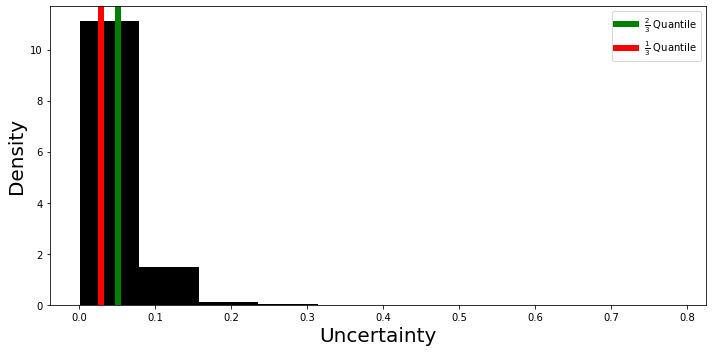

In [ ]:
for i in range(4):
    model = MF(data.n_user, data.n_item, embedding_dim=baseline.embedding_dim, lr=baseline.lr, weight_decay=baseline.weight_decay)
    train(model, data, path='checkpoints/ensemble', name=f'{i}')
    
models = [baseline]
for file in os.listdir('checkpoints/ensemble'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=baseline.embedding_dim, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble', file))
ensemble = Ensemble(models)
test(ensemble, data, name='ENSEMBLE', max_k=10)

## Resample

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 94.3 M
1 | item_embeddings | Embedding | 3.6 M 
----------------------------------------------
97.8 M    Trainable params
0         Non-trainable params
97.8 M    Total params
391.239   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 94.3 M
1 | item_embeddings | Embedding | 3.6 M 
----------------------------------------------
97.8 M    Trainable params
0         Non-trainable params
97.8 M    Total params
391.239   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 94.3 M
1 | item_embeddings | Embedding | 3.6 M 
----------------------------------------------
97.8 M    Trainable params
0         Non-trainable params
97.8 M    Total params
391.239   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 94.3 M
1 | item_embeddings | Embedding | 3.6 M 
----------------------------------------------
97.8 M    Trainable params
0         Non-trainable params
97.8 M    Total params
391.239   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 94.3 M
1 | item_embeddings | Embedding | 3.6 M 
----------------------------------------------
97.8 M    Trainable params
0         Non-trainable params
97.8 M    Total params
391.239   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


  0%|          | 0/10000 [00:00<?, ?it/s]

'Success!'

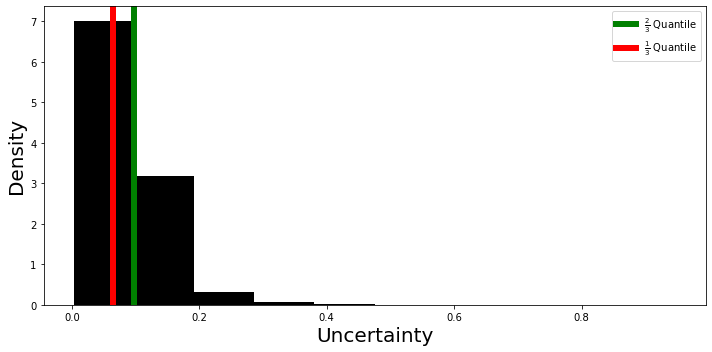

In [ ]:
og = deepcopy(data.train)
for i in range(5):
    data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
    model = MF(data.n_user, data.n_item, embedding_dim=baseline.embedding_dim, lr=baseline.lr, weight_decay=baseline.weight_decay)
    train(model, data, path='checkpoints/resample', name=f'{i}')
data.train = og

# Resample
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=baseline.embedding_dim, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(baseline, models)
test(resample, data, name='RESAMPLE', max_k=10, use_baseline=True)

## Cross-Validation

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 94.3 M
1 | item_embeddings | Embedding | 3.6 M 
----------------------------------------------
97.8 M    Trainable params
0         Non-trainable params
97.8 M    Total params
391.239   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 94.3 M
1 | item_embeddings | Embedding | 3.6 M 
----------------------------------------------
97.8 M    Trainable params
0         Non-trainable params
97.8 M    Total params
391.239   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 94.3 M
1 | item_embeddings | Embedding | 3.6 M 
----------------------------------------------
97.8 M    Trainable params
0         Non-trainable params
97.8 M    Total params
391.239   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | user_bias | Embedding | 471 K 
1 | item_bias | Embedding | 17.8 K
----------------------------------------
489 K     Trainable params
0         Non-trainable params
489 K     Total params
1.956     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

'Success!'

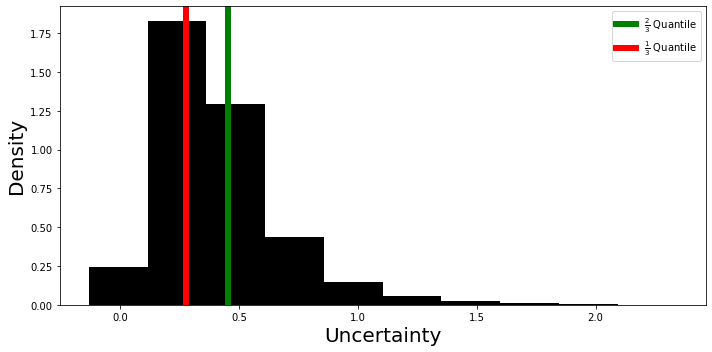

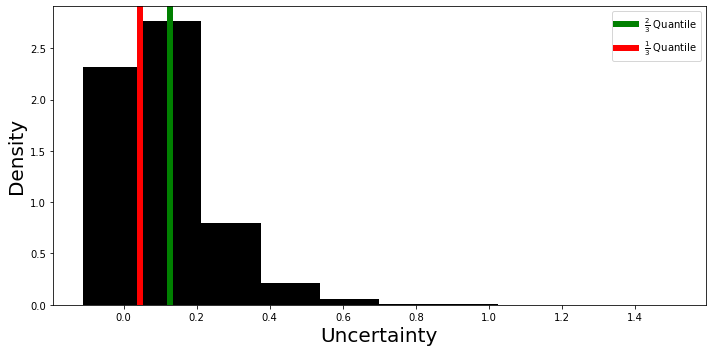

In [ ]:
def get_errors(test_array):
    pred = model.predict(torch.tensor(test_array[:, 0]).long(), torch.tensor(test_array[:, 1]).long())
    return np.abs(pred - test_array[:, 2])

errors = np.empty(len(data.train))
og = deepcopy(data.train)
og_val = deepcopy(data.val)
for i, (train_idx, test_idx) in enumerate(KFold(n_splits=2, shuffle=True).split(data.train)):
    test_rat = og[test_idx]
    data.train = og[train_idx]
    model = MF(data.n_user, data.n_item, embedding_dim=baseline.embedding_dim, lr=baseline.lr, weight_decay=baseline.weight_decay)
    train(model, data, path='checkpoints/cv', name=f'cv{i}')
    errors[test_idx] = np.concatenate([get_errors(array) for array in np.array_split(test_rat, 10)])
data.train = deepcopy(og)
data.train[:, 2] = errors
data.val[:, 2] = np.abs(model.predict(torch.tensor(data.val[:, 0]).long(), torch.tensor(data.val[:, 1]).long()) - data.val[:, 2])

# DoubleMF
model = MF(data.n_user, data.n_item, embedding_dim=baseline.embedding_dim, lr=baseline.lr, weight_decay=baseline.weight_decay)
train(model, data, path='checkpoints/cv', name=f'MF')

# Bias
model = Bias(data.n_user, data.n_item, lr=baseline.lr)
train(model, data, path='checkpoints/cv', name=f'Bias')

#Fix
data.train = og
data.val = og_val

# Zhu
for file in os.listdir('checkpoints/cv'):
    if 'Bias' in file:
        bias = Bias(data.n_user, data.n_item, lr=0)
        bias = bias.load_from_checkpoint(os.path.join('checkpoints/cv', file))
    elif 'MF' in file:
        mf = MF(data.n_user, data.n_item, embedding_dim=baseline.embedding_dim, lr=0, weight_decay=0)
        mf = mf.load_from_checkpoint(os.path.join('checkpoints/cv', file))
bias_cv = UncertainWrapper(baseline, bias)
test(bias_cv, data, name='Bias-CV', max_k=10, use_baseline=True)
mf_cv = UncertainWrapper(baseline, mf)
test(mf_cv, data, name='FunkSVD-CV', max_k=10, use_baseline=True)

## CPMF

In [ ]:
for dim in [50, 100, 200]:
    for lr in [5e-6, 1e-6]:
        model = CPMF(data.n_user, data.n_item, embedding_dim=dim, lr=0.0002, weight_decay=0, lr_var=lr)
        train(model, data, path='checkpoints/cpmf', name=f'dim={dim}-lr={lr}')

files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/cpmf') if '.ckpt' in file}
model = CPMF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/cpmf', min(files, key=files.get)))
test(model, data, name='CPMF', max_k=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 23.6 M
1 | item_embeddings | Embedding | 888 K 
2 | user_gammas     | Embedding | 471 K 
3 | item_gammas     | Embedding | 17.8 K
4 | var_activation  | Softplus  | 0     
----------------------------------------------
24.9 M    Trainable params
0         Non-trainable params
24.9 M    Total params
99.766    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: Fa

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: Lightning

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has 

  0%|          | 0/10000 [00:00<?, ?it/s]

'Success!'

## OrdRec

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 23.6 M
1 | item_embeddings | Embedding | 888 K 
2 | user_step       | Embedding | 1.9 M 
----------------------------------------------
26.3 M    Trainable params
0         Non-trainable params
26.3 M    Total params
105.350   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


  0%|          | 0/10000 [00:00<?, ?it/s]

'Success!'

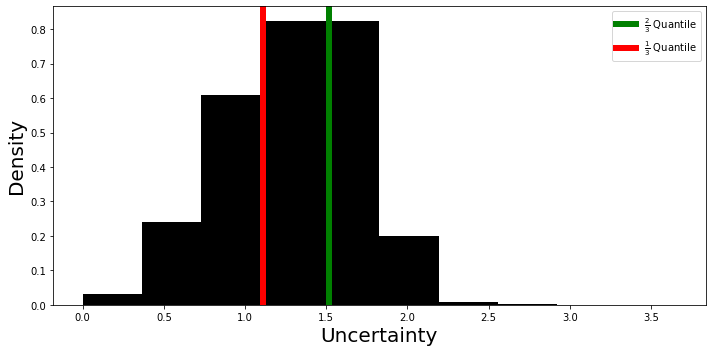

In [ ]:
data.to_ordinal()
for wd in [0.0001]:
    for lr in [0.00005]:
        model = OrdRec(data.n_user, data.n_item, data.score_labels, embedding_dim=50, lr=0.0001, weight_decay=wd, lr_step=lr)
        train(model, data, path='checkpoints/ordrec', name=f'wd={wd}-lr={lr}')

score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/ordrec')}
model = OrdRec(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/ordrec', min(files, key=files.get)))
test(model, data, name='OrdRec', max_k=10)

## BeMF

In [ ]:
data.to_ordinal()
for dim in [50]: #, 100, 200]:
    for wd in [0.001, 0.0001]:
        for lr in [0.005, 0.002]:
            model = BeMF(data.n_user, data.n_item, data.score_labels, embedding_dim=dim, lr=lr, weight_decay=wd)
            train(model, data, path='checkpoints/bemf', name=f'dim={dim}-wd={wd}-lr={lr}')

score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/bemf')}
model = BeMF(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=20)
model = model.load_from_checkpoint(os.path.join('checkpoints/bemf', min(files, key=files.get)))
test(model, data, name='BeMF', max_k=10)

# Evaluation

In [ ]:
# Baseline
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
baseline = MF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0)
baseline = baseline.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))
test(baseline, data, name='Baseline', max_k=10)

# Heuristics
test(ItemHeuristic(base_MF=baseline, uncertainty=-data.item.support.to_numpy()), data, name='NEG-ITEM-SUPPORT', max_k=10)
test(ItemHeuristic(base_MF=baseline, uncertainty=data.item.variance.to_numpy()), data, name='ITEM-VARIANCE', max_k=10)

# Ensemble
models = [baseline]
for file in os.listdir('checkpoints/ensemble'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble', file))
ensemble = Ensemble(models)
test(ensemble, data, name='ENSEMBLE', max_k=10)

# Resample
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(baseline, models)
test(resample, data, name='RESAMPLE', max_k=10)

# Zhu
for file in os.listdir('checkpoints/cv'):
    if 'Bias' in file:
        bias = Bias(data.n_user, data.n_item, lr=0)
        bias = bias.load_from_checkpoint(os.path.join('checkpoints/cv', file))
    elif 'MF' in file:
        mf = MF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0)
        mf = mf.load_from_checkpoint(os.path.join('checkpoints/cv', file))
bias_cv = UncertainWrapper(baseline, bias)
test(bias_cv, data, name='EB-LINEAR', max_k=10)
mf_cv = UncertainWrapper(baseline, mf)
test(mf_cv, data, name='EB-FunkSVD', max_k=10)

# CPMF
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/cpmf')}
model = CPMF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/cpmf', min(files, key=files.get)))
test(model, data, name='CPMF', max_k=10)

# OrdRec
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/ordrec')}
model = OrdRec(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/ordrec', min(files, key=files.get)))
test(model, data, name='OrdRec', max_k=10)

# BeMF
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/bemf')}
model = BeMF(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/bemf', min(files, key=files.get)))
test(model, data, name='BeMF', max_k=10)

Baseline - Recommending:   0%|          | 0/10000 [00:00<?, ?it/s]

NEG-ITEM-SUPPORT - Recommending:   0%|          | 0/10000 [00:00<?, ?it/s]

ITEM-VARIANCE - Recommending:   0%|          | 0/10000 [00:00<?, ?it/s]

ENSEMBLE - Recommending:   0%|          | 0/10000 [00:00<?, ?it/s]

RESAMPLE - Recommending:   0%|          | 0/10000 [00:00<?, ?it/s]

EB-LINEAR - Recommending:   0%|          | 0/10000 [00:00<?, ?it/s]

EB-FunkSVD - Recommending:   0%|          | 0/10000 [00:00<?, ?it/s]

CPMF - Recommending:   0%|          | 0/10000 [00:00<?, ?it/s]

OrdRec - Recommending:   0%|          | 0/10000 [00:00<?, ?it/s]

BeMF - Recommending:   0%|          | 0/10000 [00:00<?, ?it/s]

{'Classification': 0.5948736639129455,
 'Cuts': {'Coverage': array([1., 1., 1., 1., 1.]),
  'MAP': array([0.01309632, 0.01427287, 0.01524852, 0.01863027, 0.01941955]),
  'Map*': array([0.01309632, 0.01427287, 0.01524852, 0.01863027, 0.01941955]),
  'Relevance': array([4.99119, 4.98742, 4.98551, 4.98165, 4.97164]),
  'Surprise': array([0.00208903, 0.00227142, 0.00240991, 0.00311108, 0.00348248]),
  'Surprise*': array([0.00208903, 0.00227142, 0.00240991, 0.00311108, 0.00348248]),
  'Values': array([0.73694923, 0.71627634, 0.69303799, 0.67581735])},
 'Item_unc_corr': {'support': -0.6716966504937996,
  'variance': 0.3845310519153184},
 'Pearson error x unc': 0.15854225598698476,
 'Quantile RMSE': array([0.80427722, 0.89879687, 0.93952215, 0.96419664, 0.99094156,
        0.99921037, 0.99417073, 0.98352695, 0.9732354 , 0.94856479,
        0.92409332, 0.93212132, 1.00317617, 1.03717266, 1.07688549,
        1.11080596, 1.13865979, 1.16433395, 1.18657499, 1.33620264]),
 'RMSE': 1.02699548004482

# Plots

Baseline    0.8618
ENSEMBLE    0.8493
CPMF        0.8742
BeMF        1.0270
OrdRec      0.8666
Name: RMSE, dtype: float64
                  Pearson error x unc  Spearman error x unc      dw     RPI  \
NEG-ITEM-SUPPORT               0.0111                0.0277  0.1408  0.0233   
ITEM-VARIANCE                  0.1340                0.1089  0.3897  0.5075   
RESAMPLE                       0.0872                0.0753  0.2567  0.3632   
ENSEMBLE                       0.0405                0.0262  0.0527  0.1761   
EB-FunkSVD                     0.2161                0.1884  0.4370  0.8133   
EB-LINEAR                      0.2832                0.2398  0.7382  1.0839   
CPMF                           0.0752                0.0684  0.2174  0.2362   
BeMF                           0.1585                0.1755  0.5319  0.3726   
OrdRec                         0.2788                0.2674  0.6843  0.7673   

                  Classification  
NEG-ITEM-SUPPORT          0.5170  
ITEM-VARIANCE    

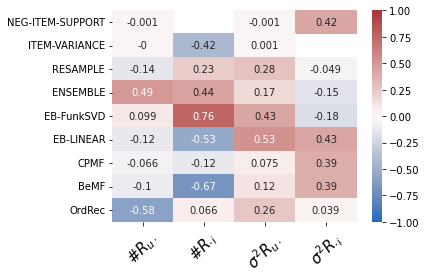

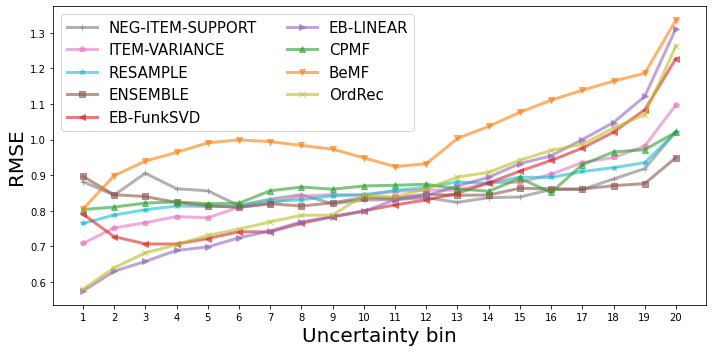

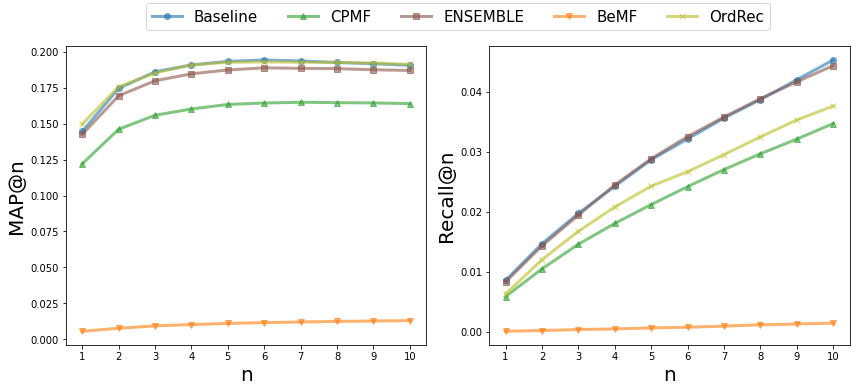

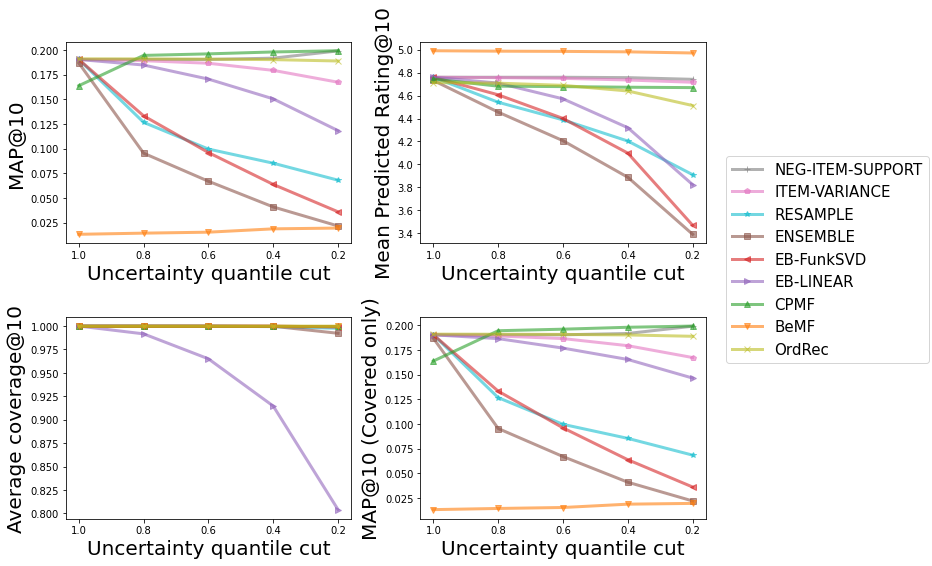

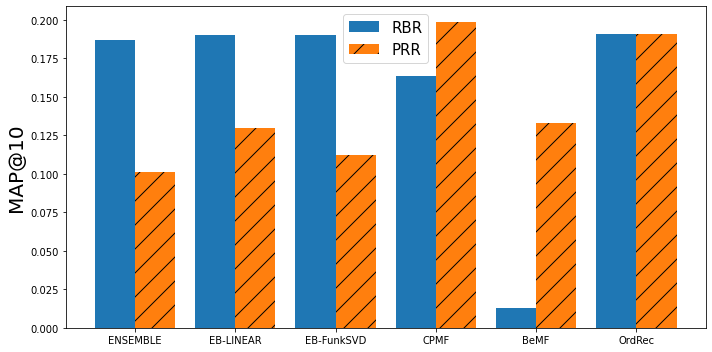

In [ ]:
# Load
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
results = dict(sorted(results.items()))
colors = [c for c in list(TABLEAU_COLORS)] + ['k']
colors = {k:c for k, c in zip(results, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p', '+', 'x', '*']
lines = {k: '-' + l for k, l, in zip(results, lines)}
df = pd.DataFrame([results[key] for key in results], index=results.keys())
order = ['NEG-ITEM-SUPPORT', 'ITEM-VARIANCE', 'RESAMPLE', 'ENSEMBLE', 'EB-FunkSVD', 'EB-LINEAR', 'CPMF', 'BeMF', 'OrdRec']

# RMSE
keys = ['Baseline', 'ENSEMBLE', 'CPMF', 'BeMF', 'OrdRec']
tab = df.loc[keys, 'RMSE'].round(4)
print(tab)
tab.to_latex(buf='plots/RMSE.txt')

# Rating prediction uncertainty
keys = [key for key in order if key != 'Baseline']
tab = df.loc[keys, ['Pearson error x unc', 'Spearman error x unc', 'dw', 'RPI', 'Classification']].round(4)
print(tab)
tab.to_latex(buf='plots/ratings_unc.txt')

# RBR uncertainty
tab = pd.DataFrame([results[key]['Rating_rec'] for key in keys], index=keys)[['URI_rec', 'Unc_MAP_corr']].round(4)
print(tab)
tab.to_latex(buf='plots/rating_URI_UAC.txt')

# UBR uncertainty
keys = ['ENSEMBLE', 'EB-FunkSVD', 'EB-LINEAR', 'CPMF', 'BeMF', 'OrdRec']
tab = pd.DataFrame([results[key]['Uncertain_rec'] for key in keys], index=keys)['Unc_MAP_corr'].round(4)
print(tab)
tab.to_latex(buf='plots/uncertain_UAC.txt')

# Correlation plot
corr = np.empty((len(results)-1, 4))
for idx, key in enumerate(order):
    corr[idx, 0] = results[key]['User_unc_corr']['support']
    corr[idx, 1] = results[key]['Item_unc_corr']['support']
    corr[idx, 2] = results[key]['User_unc_corr']['variance']
    corr[idx, 3] = results[key]['Item_unc_corr']['variance']
corr = pd.DataFrame(corr, index=order, columns=[r'#$R_{u\cdot}$', r'#$R_{\cdot i}$', r'$\sigma^2R_{u\cdot}$', r'$\sigma^2R_{\cdot i}$'])
corr.loc['NEG-ITEM-SUPPORT', r'#$R_{\cdot i}$'] = np.nan
corr.loc['ITEM-VARIANCE', r'$\sigma^2R_{\cdot i}$'] = np.nan
sns.heatmap(corr.round(3), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.xticks(rotation=45, fontsize=15)
plt.tight_layout()
plt.savefig('plots/corr.pdf')

# Uncertainty-RMSE curve
f, ax = plt.subplots(figsize=(10, 5))
for key in order:
    ax.plot(np.arange(1, 21), results[key]['Quantile RMSE'], lines[key], color=colors[key], label=key, linewidth=3, alpha=0.6)
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('Uncertainty bin', fontsize=20)
ax.set_ylabel('RMSE', fontsize=20)
ax.legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/RMSE-uncertainty.pdf')

# Top-K accuracy metrics
keys = ['Baseline', 'CPMF', 'ENSEMBLE', 'BeMF', 'OrdRec']
f, ax = plt.subplots(ncols=2, figsize=(12, 5), sharex=True)
for key in keys:
    ax[0].plot(np.arange(1, 11), results[key]['Rating_rec']['MAP'], lines[key], color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), results[key]['Rating_rec']['Recall'], lines[key], color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=len(keys), bbox_to_anchor=(0.9, 1.1))
f.tight_layout()
f.savefig('plots/accuracy.pdf', bbox_inches="tight")

# Cuts
keys = [key for key in order if key != 'Baseline']
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for key in keys:
    ax[0, 0].plot(results[key]['Cuts']['MAP'], lines[key], color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[0, 1].plot(results[key]['Cuts']['Relevance'], lines[key], color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1, 0].plot(results[key]['Cuts']['Coverage'], lines[key], color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1, 1].plot(results[key]['Cuts']['Map*'], lines[key], color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0, 0].set_xticks(range(5))
ax[0, 0].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[0, 0].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[0, 0].set_ylabel('MAP@10', fontsize=20)
ax[0, 1].set_xticks(range(5))
ax[0, 1].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[0, 1].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[0, 1].set_ylabel('Mean Predicted Rating@10', fontsize=20)
ax[1, 1].set_xticks(range(5))
ax[1, 1].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[1, 1].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[1, 1].set_ylabel('MAP@10 (Covered only)', fontsize=20)
ax[1, 0].set_xticks(range(5))
ax[1, 0].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[1, 0].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[1, 0].set_ylabel('Average coverage@10', fontsize=20)
handles, labels = ax[0, 0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, bbox_to_anchor=(1.3, 0.725))
f.tight_layout()
f.savefig('plots/cuts.pdf', bbox_inches="tight")

# Rating prediction evaluation
keys = ['ENSEMBLE', 'EB-LINEAR', 'EB-FunkSVD', 'CPMF', 'BeMF', 'OrdRec']
a = {metric: {key: [results[key]['Rating_rec'][metric][-1]] + [results[key]['Uncertain_rec'][metric][-1]] 
              for key in keys} for metric in ['MAP', 'Recall']}
precision = pd.DataFrame(a['MAP'], index=['Standard', 'Uncertain']).T
f, ax = plt.subplots(figsize=(10, 5))
ax.bar(np.arange(6)-0.2, precision['Standard'], 0.4, label='RBR')
ax.bar(np.arange(6)+0.2, precision['Uncertain'], 0.4, label='PRR', hatch='/')
ax.set_xticklabels([''] + list(precision.index))
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend(fontsize=15)
f.tight_layout()
f.savefig('plots/unc_rank.pdf')